<a href="https://colab.research.google.com/github/sameepshrestha/Object-detection/blob/main/objectdetection(YOLO)version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf 
import numpy as np 
from PIL import Image
import cv2 as cv
import os 
import h5py
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.engine import Input
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
%matplotlib inline

In [ ]:
classes=['mask','no_mask','improper_mask']
classes_map={k:i for k,i in enumerate(classes)}
reverse_map={i:k for k,i in classes_map.items()}
colours=['#FF0000','#FFFF00','#FFFFFF']
class_color_map={k:colours[i] for i,k in enumerate(reverse_map.keys())}

In [ ]:
def boxes_read(direc,f,count): #directory = direct where the text file is stored
    data=open(os.path.join(direc,f))
    classes=[]
    boxes=[]
    for lines in data:
        line=lines.split()
        if int(line[0])==2:
            count=count+1
        boxes.append([lines[0],line[1],line[2],line[3],line[4]])
    return boxes,count

In [ ]:
def read_image(direc):
    image=[]
    dist=[]
    count=0
    for f in os.listdir(direc):
        if f.endswith('.txt'):
            image_name=f.split('.')[0]
            bo,count=boxes_read(direc,f,count)#function which returns the boxes and class stored in the text file 
            dist.append(bo)
            image.append(image_name)
    print(count)
    return dist,image

In [ ]:
def create_dataset(boxees):#this converts into the output for evry individual images
    image_h=1/7                      #height and width of the single yolo box
    image_w=1/7
    box_output=np.zeros((7,7,5))
    box_classes=np.zeros((7,7,3))
    i=0
    for box in boxees:
        c_x,c_y = float(box[1]), float(box[2])
        w,h     = float(box[3]),float(box[4])
        classes = int(box[0])
        col     = int(c_x//image_w)
        row     = int(c_y//image_h)
        offset_x= (c_x/image_w-col)
        offset_y= (c_x/image_h-row)
        offset_h,offset_w=np.sqrt(h),np.sqrt(w)
        box_output[row,col,0]=1
        box_output[row,col,1],box_output[row,col,2] = offset_x,offset_y
        box_output[row,col,3],box_output[row,col,4] = offset_h,offset_w
        box_classes[row,col,classes] = 1
    boxes_image=np.zeros((7,7,8))
    boxes_image[:,:,0:5]=box_output
    boxes_image[:,:,5:]=box_classes
    return boxes_image


In [ ]:
#checkpointe_dir='/content/drive/My Drive/YOLO_small.ckpt'
#tf.train.list_variables(checkpointe_dir)

In [ ]:
def read_weights(checkpointe_dir): #reading the pretraind weights
    d={}
    d['w'+str(0)]=tf.train.load_variable(checkpointe_dir, 'Variable')
    d['w'+str(1)]=tf.train.load_variable(checkpointe_dir,'Variable_1')
    for i in range(2,50):
        d['w'+str(i)]=tf.train.load_variable(checkpointe_dir,'Variable_'+str(i))
#    return d 
        


In [ ]:
def train_dataset(direc,direc1):#something that we can return in a function ):
    boxes,images = read_image(direc) #box and the image name of the box
    size = len(images)
    print(size)
    train_x = np.zeros([size,448,448,3])
    train_y = np.zeros([size,7,7,8])
    for i in range(size):
        try:
            img=Image.open(direc1+images[i]+str('.jpg'))
        except:
            img=Image.open(direc1+images[i]+str('.png'))
            img=img.convert("RGB")
        box=create_dataset(boxes[i])
        image = img_to_array(img)
        image = image/255.0
        train_x[i,:,:,:]=image
        train_y[i,:,:,:]=box
    return train_x ,train_y

In [ ]:
direc= '/content/drive/MyDrive/object detection YOLOV1/label_img/train_files/'
direc1= '/content/drive/MyDrive/object detection YOLOV1/label_img/train_data/'
train_x,train_y=(train_dataset(direc,direc1))
print(train_y[0].shape)

1020
839
(7, 7, 8)


In [ ]:
x=read_image(direc)

157


In [ ]:
from sklearn.utils import shuffle
train_x,train_y=shuffle(train_x,train_y,random_state=45

In [ ]:
def cal_iou(bboxes1, bboxes2):
    #bboxes: [batchsize, 7, 7, 2, 4] with [center_x, center_y, h, w]
    cx, cx_ = bboxes1[:, :, :, :, 0], bboxes2[:, :, :, :, 0]
    cy, cy_ = bboxes1[:, :, :, :, 1], bboxes2[:, :, :, :, 1]
    h, h_ = bboxes1[:, :, :, :, 2], bboxes2[:, :, :, :, 2]
    w, w_ = bboxes1[:, :, :, :, 3], bboxes2[:, :, :, :, 3]
    x1, x1_ = cx - w / 2, cx_ - w_ / 2
    x2, x2_ = cx + w / 2, cx_ + w_ / 2
    y1, y1_ = cy - h / 2, cy_ - h_ / 2
    y2, y2_ = cy + h / 2, cy_ + h_ / 2
    x_inter1 = tf.maximum(x1, x1_)
    x_inter2 = tf.minimum(x2, x2_)
    y_inter1 = tf.maximum(y1, y1_)
    y_inter2 = tf.minimum(y2, y2_)
    h_inter = tf.maximum(0., y_inter2 - y_inter1)
    w_inter = tf.maximum(0., x_inter2 - x_inter1)
    area_inter = h_inter * w_inter
    area_union = h * w + h_ * w_ - area_inter
    iou = area_inter / area_union
    return iou


In [ ]:
def model_tiny_yolov1(inputs):
    x = Conv2D(16, (3, 3), padding='same',name='convolutional_0',use_bias=False, trainable=False)(inputs)
    x = BatchNormalization(name='bnconvolutional_0',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same',name='convolutional_1', use_bias=False,trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_1',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same',name='convolutional_2', use_bias=False,trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_2',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same', name='convolutional_3', use_bias=False,trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_3',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_4', use_bias=False,trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_4',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(512, (3, 3), padding='same', name='convolutional_5', use_bias=False,trainable=False)(x)
    x = BatchNormalization(name='bnconvolutional_5',trainable=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = Conv2D(1024, (3, 3), padding='same', name='convolutional_6', use_bias=False,trainable=True)(x)
    x = BatchNormalization(name='bnconvolutional_6',trainable=True)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(256, (3, 3), padding='same', name='convolutional_7', use_bias=False,trainable=True)(x)
    x = BatchNormalization(name='bnconvolutional_7',trainable=True)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)
    x = Dense(1470,activation='relu')(x)
    x = Dense(637,activation='sigmoid')(x)

    
    # outputs = Reshape((7, 7, 12))(x)
    outputs = Reshape((7, 7, 13))(x)
    my_model=Model(inputs=inputs,outputs=outputs)
    return my_model

In [ ]:
weight_hdf5='/content/drive/My Drive/object detection YOLOV1/tiny-yolov1.hdf5'
inputs=Input((448,448,3))
model=model_tiny_yolov1(inputs) #inputs ko name halna paryo
model.load_weights(weight_hdf5,by_name='True')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
convolutional_0 (Conv2D)     (None, 448, 448, 16)      432       
_________________________________________________________________
bnconvolutional_0 (BatchNorm (None, 448, 448, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 448, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 16)      0         
_________________________________________________________________
convolutional_1 (Conv2D)     (None, 224, 224, 32)      4608      
_________________________________________________________________
bnconvolutional_1 (BatchNorm (None, 224, 224, 32)     

In [ ]:

def yolo_loss(labels, prediction):#prediction (box predicted by the deep network size(batchsize:7:7,12))and the labels are the training dataset (batchsize:,7,7,8)
    pred_bboxes = prediction[:, :, :, 0:8] #the two boxes predictedsize=[batchsize,7,7,8]
    pred_bboxes = tf.reshape(pred_bboxes, [-1, 7, 7, 2, 4]) #reshape to [batchsize,7,7,2,4]
    pred_confidence = prediction[:, :, :, 8:10] #predicted confidence score of both the boxes
    pred_class = prediction[:, :, :, 10:] #all the classes present 
    #groundtruth
    label_mask = labels[:, :, :, 0:1] #if the object is present or  not 
    label_bboxes = labels[:, :, :, 1:5]#the ground truth box since only one box per block is present [batchsize,7,7,4]
    label_bboxes = tf.tile(label_bboxes, multiples=[1, 1, 1, 2])#copy the boxes for comparing with the predicted [batchsize,7,7,8]
    label_bboxes = tf.reshape(label_bboxes, [-1, 7, 7, 2, 4])#reshape to match[battchsize:,:,2,4]
    label_class = labels[:, :, :, 5:]#the classes present in the traininge set 
    #prediction normalized offset -> [c_x, c_y, h, w]
    cell_h = 1 / 7
    cell_w = 1 / 7
    temp = tf.constant([[0., 1., 2., 3., 4., 5., 6.]])
    temp = tf.tile(temp, multiples=[7, 1]) #check the lower part of these notebook 
    col = temp[tf.newaxis, :, :, tf.newaxis, tf.newaxis]#dimension 7 x 7 -> 1 x 7 x 7 x 1 x 1
    row = tf.transpose(col, perm=[0, 2, 1, 3, 4])#ok done 
    pred_bboxes_original = tf.concat([(pred_bboxes[:, :, :, :, 0:1] + col) * cell_w,
                                      (pred_bboxes[:, :, :, :, 1:2] + row) * cell_h,
                                       tf.square(pred_bboxes[:, :, :, :, 2:3]) ,
                                       tf.square(pred_bboxes[:, :, :, :, 3:4]) ], axis=-1)
    label_bboxes_original = tf.concat([(label_bboxes[:, :, :, :, 0:1] + col) * cell_w,
                                      (label_bboxes[:, :, :, :, 1:2] + row) * cell_h,
                                      tf.square(label_bboxes[:, :, :, :, 2:3]) ,
                                      tf.square(label_bboxes[:, :, :, :, 3:4]) ], axis=-1)
    
    iou = cal_iou(pred_bboxes_original, label_bboxes_original)#input: batchsize x 7 x 7 x 2 x 4, output: batchsize x 7 x 7 x 2
    max_iou = tf.reduce_max(iou, axis=-1, keepdims=True)#output: batchsize x 7 x 7 x 1
    mask_obj = tf.cast(tf.greater_equal(iou, max_iou), dtype=tf.float32) * label_mask
    loss_bboxes = tf.reduce_mean(tf.reduce_sum(tf.square(pred_bboxes - label_bboxes) * mask_obj[:, :, :, :, tf.newaxis], axis=[1, 2, 3, 4]))#ok upto here
    loss_confidence_obj = tf.reduce_mean(tf.reduce_sum(tf.square(pred_confidence - 1) * mask_obj, axis=[1, 2, 3]))
    loss_confidence_noobj = tf.reduce_mean(tf.reduce_sum(tf.square(pred_confidence) * (1 - mask_obj), axis=[1, 2, 3]))
    loss_class = tf.reduce_mean(tf.reduce_sum(tf.square(pred_class - label_class) * label_mask, axis=[1, 2, 3]))
    loss = 5 * loss_bboxes + loss_confidence_obj + 0.5 * loss_confidence_noobj + loss_class
    return loss

In [ ]:
#training the model 
opt= tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss=yolo_loss, optimizer=opt)
model.fit(train_x,train_y,epochs=150,batch_size=16)

Epoch 1/150
53/53 [==============================] - 3s 62ms/step - loss: 77.7888
Epoch 2/150
53/53 [==============================] - 3s 57ms/step - loss: 72.0545
Epoch 3/150
53/53 [==============================] - 3s 57ms/step - loss: 63.8028
Epoch 4/150
53/53 [==============================] - 3s 58ms/step - loss: 56.4830
Epoch 5/150
53/53 [==============================] - 3s 56ms/step - loss: 51.4641
Epoch 6/150
53/53 [==============================] - 3s 56ms/step - loss: 48.8120
Epoch 7/150
53/53 [==============================] - 3s 57ms/step - loss: 47.3439
Epoch 8/150
53/53 [==============================] - 3s 56ms/step - loss: 46.5565
Epoch 9/150
53/53 [==============================] - 3s 56ms/step - loss: 45.8747
Epoch 10/150
53/53 [==============================] - 3s 56ms/step - loss: 45.4654
Epoch 11/150
53/53 [==============================] - 3s 56ms/step - loss: 45.2162
Epoch 12/150
53/53 [==============================] - 3s 58ms/step - loss: 44.9477
Epoch 13/150


In [ ]:
!pip install pyyaml h5py

In [ ]:
#model.save_weights('/content/drive/MyDrive/savedmodel/model',save_format='h5')

In [ ]:
model.save('/content/drive/MyDrive/savedmodel/model2.h5')

In [ ]:

#drawing the box int the predicted image starts here
def normalized_to_center(pred_boxes):
    cell_h=1/7
    cell_w=1/7
    column = np.array([0.0,1.0,2.0,3.0,4.0,5.0,6.0])
    colum=np.tile(column,(7,1))
    col=colum[np.newaxis,:,:,np.newaxis,np.newaxis]
    row=np.transpose(col,(0,2,1,3,4))
    c_x,c_y=(pred_boxes[:,:,:,:,0:1]+col)*cell_w,(pred_boxes[:,:,:,:,1:2]+row)*cell_h
    c_h,c_w=np.square(pred_boxes[:,:,:,:,2:3]),np.square(pred_boxes[:,:,:,:,3:4])
    return c_x,c_y,c_h,c_w

    

In [ ]:
def boxes_to_corner(c_x,c_y,h,w):
    boxes=np.zeros((1,7,7,2,4))
    boxes[:,:,:,:,0:1]=c_y-h/2
    boxes[:,:,:,:,1:2]=c_x-w/2
    boxes[:,:,:,:,2:3]=c_y+h/2
    boxes[:,:,:,:,3:4]=c_x+h/2 #fomat(y1 ,x1,y2,x2) recquired for non max supression
    return boxes


In [ ]:

def yolo_filter_boxes(pred_corners,pred_class,pred_confidence,thresold):
    clas            = tf.math.argmax(pred_class,axis=-1)#[:,:,:,1][class index with the maximum value]
    score           = tf.reduce_max(pred_class,axis=-1)
    clas            = tf.reshape(clas,[7,7,1])
    scores_class    = tf.reshape(score,[7,7,1])
    class_index     = tf.reshape(tf.tile(clas,[1,1,2]),[-1])    #copy the calsses for the two boxes
    scores          = pred_confidence*scores_class #(both shaoe[:,:,:,2]) so must be elemental multiplication  
    scores          = tf.reshape(scores,[-1])
    predboxes       = tf.reshape(pred_corners,[-1,4])
    filtering_mask  = scores>thresold #thresold need to change for others 
    scores          = tf.boolean_mask(scores,filtering_mask)
    boxes           = tf.boolean_mask(predboxes,filtering_mask,axis=0)
    classes         = tf.boolean_mask(class_index,filtering_mask)
    print(scores)
    return scores,boxes,classes

In [ ]:
def non_max_supression(boxes,scores,classes):
    
    boxes=tf.cast(boxes,dtype=tf.float32)
    nms_index       = tf.image.non_max_suppression(boxes,scores,10,iou_threshold=.4)
    scores          = tf.gather(scores, nms_index)
    boxes           = tf.gather(boxes, nms_index)
    classes         = tf.gather(classes, nms_index)
    print(classes)
    return scores,boxes,classes

In [ ]:
def predict(test_data_path):
  image = cv.imread(test_data_path)
  input_shape = (1, 448, 448, 3)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  image = cv.resize(image, input_shape[1:3])
  image = np.reshape(image, input_shape)
  image = image/255.0
  inputs = Input(input_shape[1:4])
  y = model.predict(image, batch_size=1)
  return y

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def bb0x_to_rectangle(x1,y1,w,h,color):
    return plt.Rectangle(xy=(x1,y1),width=w,height=h,edgecolor=color,linewidth=1,facecolor='none')
def text(x1,y1,label,color):
    return plt.text(x1+8,y1-10,label,fontsize=10,bbox=dict(facecolor=color, alpha=0.5))
# draw all results
def display_boxes(filename, scores,boxes, labels):
    img1=Image.open(filename)
    img1=img1.resize([448,448])
    img1=plt.imshow(img1)
    for i in range(boxes.shape[0]): # boxes are bounding boxes
        y1, x1, y2, x2 =boxes[i,0:1]*448,boxes[i,1:2]*448,boxes[i,2:3]*448,boxes[i,3:4]*448 # it has boxes's coordinates
        w=(x2-x1)
        h=(y2-y1)
        label = (classes[labels[i]]) # get the string label corresponding to the class
        color = colours[labels[i]]
        print(label) # associate color to the appropriate class
        img1.axes.add_patch(bb0x_to_rectangle(x1,y1,w,h,color))
        (text(x1,y1,label,color))


In [ ]:
def box(image_path):# prediction is the output of the convolutional layer 
    #input shape in the model is [1,input_shape]
    #check the shape of the train_x
    #step 1 extract the boxes ,the labels ,the confifdence interval
    #send to model to predict hre image of shape 448,448,3
    prediction=predict(image_path)
    pred_bboxes          = prediction[0, :, :, 0:8] #the two boxes predictedsize=[batchsize,7,7,8]
    pred_bboxes          = tf.reshape(pred_bboxes, [1, 7, 7, 2, 4]) #reshape to [batchsize,7,7,2,4]
    pred_confidence      = prediction[0, :, :, 8:10] #predicted confidence score of both the boxes
    pred_class           = prediction[0, :, :, 10:] #all the classes present
    c_x,c_y,c_h,c_w      = normalized_to_center(pred_bboxes) 
    boxes=boxes_to_corner(c_x,c_y,c_h,c_w)
    scores,boxes,classes = yolo_filter_boxes(boxes,pred_class,pred_confidence,thresold=.35)
    scores,boxes,classes = non_max_supression(boxes,scores,classes)
    display_boxes(image_path,scores,boxes,classes)
   
    #thresold for classes be .4 and that for the iou be .5 


In [ ]:
import time 

tf.Tensor([0.37007523], shape=(1,), dtype=float32)
tf.Tensor([0], shape=(1,), dtype=int64)
mask


-0.5088291168212891

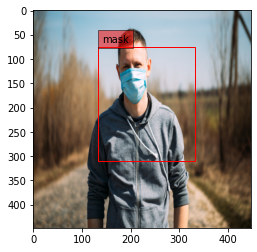

In [ ]:
a=time.time()
image='/content/masked-man-outdoors-after-quarantine_93200-2827.jpg'
box(image)
b=time.time()

a-b

tf.Tensor([0.9026265], shape=(1,), dtype=float32)
tf.Tensor([1], shape=(1,), dtype=int64)
no_mask


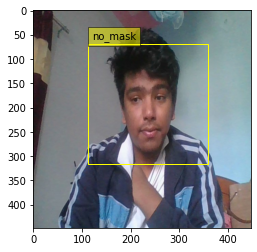

In [ ]:
image='/content/WIN_20201124_09_48_00_Pro.jpg'
box(image)

tf.Tensor([0.9644687], shape=(1,), dtype=float32)
tf.Tensor([1], shape=(1,), dtype=int64)
no_mask


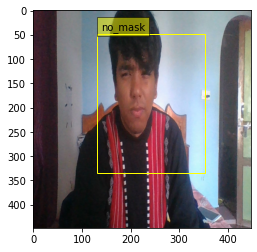

In [ ]:

image='/content/WIN_20201119_08_06_53_Pro.jpg'
box(image)

tf.Tensor([0.44668427], shape=(1,), dtype=float32)
tf.Tensor([0], shape=(1,), dtype=int64)
mask


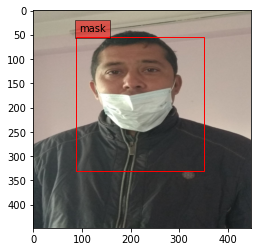

In [ ]:
image='/content/126011584_416681602689404_2295046699149671033_n.jpg'
box(image)

tf.Tensor([0.93020415], shape=(1,), dtype=float32)
tf.Tensor([0], shape=(1,), dtype=int64)
mask


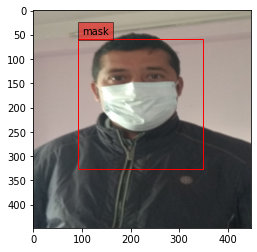

In [ ]:
image='/content/126616536_496521677918225_3841250566437280755_n.jpg'
box(image)

tf.Tensor([0.8438454], shape=(1,), dtype=float32)
tf.Tensor([0], shape=(1,), dtype=int64)
mask


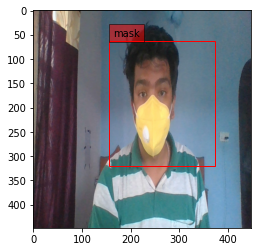

In [ ]:
image='/content/WIN_20201119_13_32_09_Pro.jpg'
box(image)

In [ ]:
#non maxx supression not working properly 
#images trained are not of size 448 ,448 


In [ ]:
#Real time detection 